Import Libraries


In [1]:
# ✅ Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.12.0


In [5]:
# ✅ Step 2: Define Paths and Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

train_path = "SkinDisease/train"
test_path = "SkinDisease/test"

# Optional: Count classes
num_classes = len(os.listdir(train_path))
print("Number of Classes:", num_classes)

Number of Classes: 9


In [6]:
# ✅ Step 3: Data Augmentation
train_aug = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
)

test_aug = ImageDataGenerator(rescale=1.0 / 255)

train_data = train_aug.flow_from_directory(
    train_path, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

test_data = test_aug.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 3139 images belonging to 9 classes.
Found 491 images belonging to 9 classes.


In [7]:
# ✅ Step 4: Build Model using EfficientNetB0
base_model = EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze base layers

model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                                 
Total params: 4,379,820
Trainable params: 330,249
Non-trainable params: 4,049,571
________________________________________

In [8]:
# ✅ Step 5: Train Initial Model
history = model.fit(train_data, validation_data=test_data, epochs=10)

Epoch 1/10
99/99 [==============================] - 304s 3s/step - loss: 2.1026 - accuracy: 0.2083 - val_loss: 2.1392 - val_accuracy: 0.2322
Epoch 2/10
99/99 [==============================] - 310s 3s/step - loss: 2.0813 - accuracy: 0.2265 - val_loss: 2.1158 - val_accuracy: 0.2322
Epoch 3/10
99/99 [==============================] - 312s 3s/step - loss: 2.0713 - accuracy: 0.2262 - val_loss: 2.1105 - val_accuracy: 0.2322
Epoch 4/10
99/99 [==============================] - 306s 3s/step - loss: 2.0660 - accuracy: 0.2294 - val_loss: 2.1154 - val_accuracy: 0.2322
Epoch 5/10
99/99 [==============================] - 308s 3s/step - loss: 2.0737 - accuracy: 0.2284 - val_loss: 2.1070 - val_accuracy: 0.2322
Epoch 6/10
99/99 [==============================] - 324s 3s/step - loss: 2.0718 - accuracy: 0.2255 - val_loss: 2.1318 - val_accuracy: 0.2322
Epoch 7/10
99/99 [==============================] - 343s 3s/step - loss: 2.0678 - accuracy: 0.2291 - val_loss: 2.1137 - val_accuracy: 0.2322
Epoch 8/10
99

In [ ]:
# ✅ Step 6: Fine-Tune Model (for better accuracy)
base_model.trainable = True  # Unfreeze the base model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

fine_tune_history = model.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
99/99 [==============================] - 1017s 10s/step - loss: 2.7345 - accuracy: 0.1004 - val_loss: 2.1211 - val_accuracy: 0.2322
Epoch 2/15
99/99 [==============================] - 694s 7s/step - loss: 2.3310 - accuracy: 0.1602 - val_loss: 2.1404 - val_accuracy: 0.2322
Epoch 3/15
99/99 [==============================] - 883s 9s/step - loss: 2.1008 - accuracy: 0.2428 - val_loss: 2.1292 - val_accuracy: 0.2281
Epoch 4/15
99/99 [==============================] - 746s 8s/step - loss: 1.9877 - accuracy: 0.2985 - val_loss: 2.1506 - val_accuracy: 0.2077
Epoch 5/15
99/99 [==============================] - 698s 7s/step - loss: 1.8859 - accuracy: 0.3479 - val_loss: 2.0887 - val_accuracy: 0.2485
Epoch 6/15
99/99 [==============================] - 659s 7s/step - loss: 1.8293 - accuracy: 0.3727 - val_loss: 1.9245 - val_accuracy: 0.2994
Epoch 7/15
99/99 [==============================] - 670s 7s/step - loss: 1.7679 - accuracy: 0.3963 - val_loss: 1.8129 - val_accuracy: 0.3951
Epoch 8/15


In [14]:
# ✅ Step 7: Evaluate & Save Model
loss, acc = model.evaluate(test_data)
print(f"\nFinal Test Accuracy: {acc*100:.2f}%")

model.save("skin_disease_model.h5")

16/16 [==============================] - 23s 1s/step - loss: 1.6247 - accuracy: 0.4114

Final Test Accuracy: 41.14%


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [7]:
# ✅ Step 8: Plot Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(
    history.history["accuracy"] + fine_tune_history.history["accuracy"],
    label="Train Accuracy",
)
plt.plot(
    history.history["val_accuracy"] + fine_tune_history.history["val_accuracy"],
    label="Val Accuracy",
)
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'fine_tune_history' is not defined

<Figure size 1000x500 with 0 Axes>

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = (
    r"C:\Users\sahil\OneDrive\Desktop\mediscan\SkinDisease\train\Acne\07Acne081101.jpeg"
)
IMG_SIZE = (224, 224)

# Model Load
model = tf.keras.models.load_model("skin_disease_model.h5")

# Image Load & Preprocess
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
pred = model.predict(img_array)
predicted_class = np.argmax(pred, axis=1)
print("Predicted class index:", predicted_class[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class index: 17


In [17]:
# ✅ Step 3: Define Class Labels (must match training order)
class_names = sorted(os.listdir("SkinDisease/train"))  # same folder used in training
print("Detected Classes:", class_names)

Detected Classes: ['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


In [18]:
# ✅ Step 4: Image Preprocessing + Prediction
def predict_skin_disease(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100

    # Show image + prediction
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.show()

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


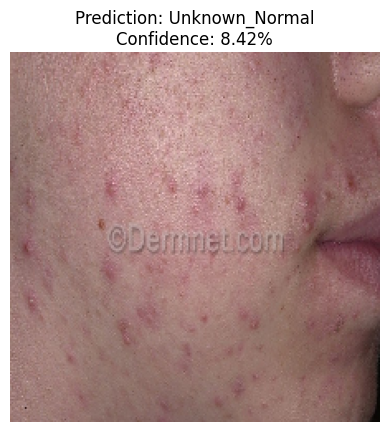

('Unknown_Normal', 8.424539864063263)

In [20]:
# ✅ Step 5: Test with an Image
# Replace 'test_image.jpg' with your actual file path
test_image_path = "C:\\Users\\sahil\\OneDrive\\Desktop\\mediscan\\SkinDisease\\train\\Acne\\07Acne081101.jpeg"
predict_skin_disease(test_image_path)